# Your First RNN

**Exercise objectives**:

- Better understand temporal data
- Build your first Recurrent Neural Network


<hr>
<hr>

## 1. The data

Let's start with simple sequences of observations:

In [3]:
from tensorflow import keras
import numpy as np

In [13]:
#Load the files X.sav and Y.sav and store them in two arrays X and y
X = np.load('X.sav', allow_pickle=True)
y = np.load("Y.sav", allow_pickle=True)

In [8]:
print(X.shape)
print(X[0])

(25000, 10, 3)
[[  1.436 113.    197.   ]
 [  1.725 116.    197.   ]
 [  2.144 116.    197.   ]
 [  2.202 116.    197.   ]
 [  2.341 116.    166.   ]
 [  2.449 143.    166.   ]
 [  6.088 143.    108.   ]
 [  6.169 107.    108.   ]
 [  2.656 107.    108.   ]
 [  2.848 107.    108.   ]]


In [14]:
print(y.shape)
print(y[0])

(25000,)
2.872


☝️ The data describes the evolution of the **employment status of a person, year after year**: each sequence corresponds to 10 consecutive years, where each year describes a job situation, comprising of 3 components
- the salary,
- the number of persons under one's responsability,
- the size of the company. 

So, from this 25000 sequences, each of 10 consecutive observations, the goal is to predict the salary on the 11th year based on the past observations. 

❓ **Question** ❓ Take some sequences and plot the evolution of their salaries, of the persons under their responsibility and of the company sizes. You might see some correlation between the three variables.

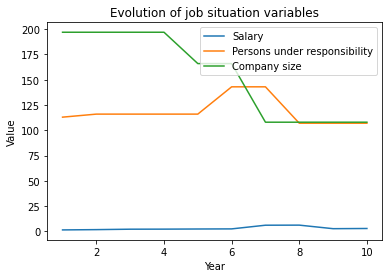

In [25]:
import matplotlib.pyplot as plt

salaries = [job[0] for job in X[0]]
persons = [job[1] for job in X[0]]
companies = [job[2] for job in X[0]]

plt.plot(range(1, 11), salaries, label='Salary')
plt.plot(range(1, 11), persons, label='Persons under responsibility')
plt.plot(range(1, 11), companies, label='Company size')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Evolution of job situation variables')
plt.show()

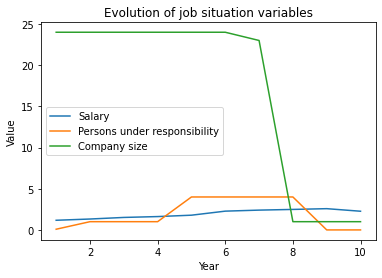

In [33]:
import matplotlib.pyplot as plt

salaries = [job[0] for job in X[1]]
persons = [job[1] for job in X[1]]
companies = [job[2] for job in X[1]]

plt.plot(range(1, 11), salaries, label='Salary')
plt.plot(range(1, 11), persons, label='Persons under responsibility')
plt.plot(range(1, 11), companies, label='Company size')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Evolution of job situation variables')
plt.show()

❓ **Question** ❓ Plot the distribution of all the salaries, persons under one's responsibility, and company sizes to get a better understanding of the variability of observations

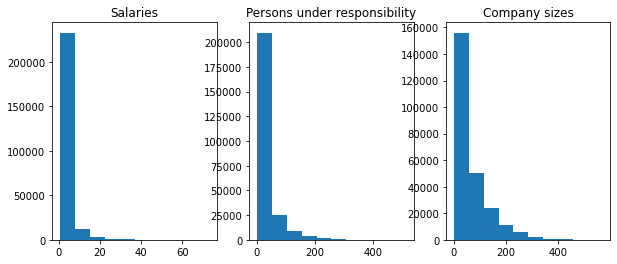

In [34]:
salaries = np.array(X)[:, :, 0].flatten()
persons = np.array(X)[:, :, 1].flatten()
sizes = np.array(X)[:, :, 2].flatten()

# plot histograms
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].hist(salaries)
axs[0].set_title("Salaries")
axs[1].hist(persons)
axs[1].set_title("Persons under responsibility")
axs[2].hist(sizes)
axs[2].set_title("Company sizes")
plt.show()

❓ **Question** ❓  Split your dataset between a train and test set (20/80%)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# print the shapes of the train and test sets
print("X_train shape:", np.shape(X_train))
print("X_test shape:", np.shape(X_test))

X_train shape: (20000, 10, 3)
X_test shape: (5000, 10, 3)


# 2. A Simple RNN

Now, you will create your first Recurrent Neural Network. Let's start simple

❓ **Question** ❓ Write a model that has: 
- a `Normalization` layer adapted on the training set
- a `SimpleRNN` layer with 20 `units` - don't forget to choose the `tanh` activation function
- a Dense layer with 10 neurons
- a last Dense layer specific to your task (predict a salary)

Remember, you don't need to specify an `input_shape`: as soon as your normalizer has been adapted to your train set, it has memorized it.

In [64]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, Normalization

# YOUR CODE HERE
# Define the model
normalizer = Normalization()
normalizer.adapt(X_train)

model = Sequential([
    # Normalization layer adapted on the training set
    normalizer,
    # SimpleRNN layer with 20 units and tanh activation function
    SimpleRNN(20, activation='tanh'),
    # Dense layer with 10 neurons
    Dense(10, activation='relu'),
    # Last Dense layer specific to the task of predicting a salary
    Dense(1, activation="linear")
])

❓ **Question** ❓ Compute the number of trainable parameters of your model using `model.summary`. 

Then, try to recompute them by hand

💡 Hints: 
- Your `normalization` layer has 7 non-trainable params, which comprise of the mean and standard deviation of each 3 features (salary, persons under responsibility, company size) plus one bias set to 0

- If $\color{green}{n_h}$ RNN units are applied in parallel to $\color{red}{n_x}$ features, the layer has $\color{green}{n_h}(\color{green}{n_h} + \color{red}{n_x} + 1)$ parameters to train. Notice how this number is *independent* of the length of each sequences (here 10 days)


In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 20)                480       
                                                                 
 dense_14 (Dense)            (None, 10)                210       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 708
Trainable params: 701
Non-trainable params: 7
_________________________________________________________________


❓ **Question** ❓ Compile your model. Remember to first use the `rmsprop` optimizer (instead of Adam).

In [81]:
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics = "MAE")

❓ **Question** ❓ Run your model on your data. Use a validation split of 20% and an early stopping criterion (patience=5). Evaluate your performance on the test set

In [82]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criterion
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop])


# Evaluate the model on the test set and compute test MAE
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"test loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
487/500 [============================>.] - ETA: 0s - loss: 0.6298 - MAE: 0.3205WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002189EC30820> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source

# Baseline comparison?


In the case of a usual regression model, a baseline prediction for `y_test` could be to predict the average of `y_train`.

With temporal data, it often happens that you try to predict a value that you have already seen in the past: here, the salary. In that case, a baseline model could be to predict for instance that the 11-th salary is equal to the 10-th salary.

❓ **Question** ❓ Compute the Mean Absolute Error of a model that would predict that the salary remains constant between the 10-th and 11-th year and compare it to your RNN.

In [83]:
y_pred = X_test[:,9,0]
np.mean(np.abs(y_test - y_pred))

0.5367846

You have probably seen that your prediction is a little bit better than the baseline model

# LSTM

❓ **Question** ❓ Write the exact same model, but with a `LSTM` instead of a `SimpleRNN` and evaluate your performance on the test set

In [86]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, Normalization, LSTM

# YOUR CODE HERE
# Define the model
normalizer = Normalization()
normalizer.adapt(X_train)

model = Sequential([
    # Normalization layer adapted on the training set
    normalizer,
    # SimpleRNN layer with 20 units and tanh activation function
    LSTM(20, activation='tanh'),
    # Dense layer with 10 neurons
    Dense(10, activation='relu'),
    # Last Dense layer specific to the task of predicting a salary
    Dense(1, activation="linear")
])

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics = "MAE")


# Define early stopping criterion
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop])


# Evaluate the model on the test set and compute test MAE
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"test loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
494/500 [============================>.] - ETA: 0s - loss: 17.3502 - MAE: 1.9089WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000218D6B3CD30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but sourc

## 🏁 Congratulation

You now know how to run RNN on sequence data!

Note: The sequences you worked with are totally fake. In case you need to train and reproduce similar data, you can find bellow the functions that have been used to simulate this data.

# Utils (for reference only)

In [23]:
def create_sequences(number):
    X, y = [], []
    
    for i in range(number):
        x_i, y_i = create_individual_sequence(10)
        X.append(x_i)
        y.append(y_i)
        
    return np.array(X), np.array(y)
            
def create_individual_sequence(length):
    company_sizes = []
    nb_persons = []
    salaries = []
    
    
    # Education level
    educ_level = [max(0, int(np.random.normal(10, 2)))]*length
    
    # Company size
    current_size = int(1 + np.random.beta(.4, 4)*500)
    for i in range(length):
        if not np.random.randint(4): # Change 1 out of 3 possibilities 
            current_size = int(max(1, np.random.normal(current_size, 50)))
        company_sizes.append(current_size)
    
    # Number of persons
    nb_iter = np.random.beta(.15, 4)*300
    for i in range(length):
        if not np.random.randint(2): # Change 1 out of 2 possibilities
            R_1 = np.random.beta(0.5, 8)*3
            nb_iter = nb_iter + max(-2, R_1*company_sizes[i] + np.random.randint(-2, 2))
            nb_iter = max(0, nb_iter)
            nb_iter = int(min(company_sizes[i]-1, nb_iter))
        nb_persons.append(nb_iter)
        
    
    # Salary
    salary_iter = max(800, int(np.random.normal(1200, 300)+ 0.05*company_sizes[0] +  np.random.normal(40, 400)))
    salaries.append(salary_iter)
    for i in range(1, length + 1):
        R_1 = np.random.normal(100, 50)
        change_person = nb_persons[i-1] - nb_persons[i-2]
        change_company = max(0, company_sizes[i-1] - company_sizes[i-2])
        salary_iter = salary_iter + 0.05*change_company + change_person*R_1 + np.random.normal(100, 50)
        salary_iter = max(int(salary_iter), 500)
        
        salaries.append(salary_iter)

    y = salaries[-1]/1000
    salaries = [_/1000 for _ in salaries[:-1]]
    
    return np.array([salaries, nb_persons, company_sizes]).T, y

In [24]:
#X, y = create_sequences(25000)

#np.save('X', X.astype(np.float32))
#np.save('y', y)